#Casting the Net:  Machine Learning for Phishing Website Detection

Phishing is a common source of fraud on the internet that can have
devastating effects on the lives of its victims. The goal of this project is to
produce a model that can quickly identify whether or not a URL presented to a
user is malicious as well as provide an intuitive understanding as to why the
URL in question is malicious (or not) by extracting insights from the model
itself using established techniques such as feature importance and partial
dependence plotting. The dataset used is composed of approximately 59,000
training examples with 111 features in total (the features are categorised into
implicit groups that correspond to specific parts of a URLs anatomy such as
the domain or protocol). Binary Cross-Entropy loss, accuracy, precision,
recall, and confusion matrices will be used to evaluate the performance of the
model. The main challenges will likely revolve around extracting meaningful
insights from the trained model using the previously mentioned techniques;
their respective implementations are likely to give way to unforeseen
challenges that will need to be dealt with.

##the problem
Users online are often not capable of distinguishing malicious URLs from
legitimate ones. While anti-phishing tools like spam filters and browser plugins
are often successful in preventing exposure to malicious websites, they fail to
educate the user as to why the URL in question was malicious to begin with.
This leaves the user vulnerable to phishing attacks when such tools
malfunction, or simply not at their disposal, hence the reason why it is
important that users are able to leverage learned intuitions to avoid phishing
attacks unassisted.

##the solution
The solution consists of two parts: 

The classification of an URL as legitimate
or malicious using a binary logistic regression model.

Feature contribution will be used to determine which features, and even groups of
features (the datasets features are categorised into non-overlapping groups
that pertain to the structure of a URL) play a role in the result of the
classification. The goal of this is to pinpoint patterns and elements that they
are likely to identify in other malicious URLs they may come across.

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sklearn.ensemble
import sklearn.inspection
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


##**Data Processing**

Total number of instances: 88,647 \\
Number of legitimate website instances (labeled as 0): 58,000 \\
Number of phishing website instances (labeled as 1): 30,647 \\
Total number of features: 111 \\

train size = 62052 samples (70% of dataset) \\
test size = 26595 samples (30% of the dataset)

**why use a unbalanced dataset?**

Due to the fact that most websites are legitimate rather than fraudulent, the imbalance reflects the reality of the problem space. While the code below can be configured to use a balanced or imbalanced dataset, the model performs better when the unbalanced dataset is used. 

In [11]:
dataset = pd.read_csv('dataset_full.csv')

feature_names = list(dataset.columns.values)[:111]
num_features = len(feature_names)

useBalanced = False

dataset_phishing = dataset[dataset["phishing"] == 1]
dataset_safe = dataset[dataset["phishing"] == 0]

if useBalanced == True:
  dataset = pd.concat([dataset_phishing, dataset_safe[:len(dataset_phishing)]], axis=0).sample(frac=1)
else: 
  dataset = pd.concat([dataset_phishing, dataset_safe], axis=0).sample(frac=1)

train, test = train_test_split(dataset, test_size=0.3)

X_train = train.iloc[:, 0:111]
y_train = train['phishing']

X_test = test.iloc[:, 0:111]
y_test = test['phishing']

#necessary conversion of the training and testing Pandas dataframes into PyTorch tensors 
X_train_torch = torch.Tensor(X_train.values)
y_train_torch = torch.Tensor(y_train.values)

X_test_torch = torch.Tensor(X_test.values)
y_test_torch = torch.Tensor(y_test.values)

In [12]:
# dataset = pd.read_csv('dataset_full.csv')

# feature_names = list(dataset.columns.values)[:111]
# num_features = len(feature_names)

# #split the dataset into a training and test set
# #train size = 62052 samples (70% of dataset)
# #test size = 26595 samples (30% of the dataset)
# dataset_phishing = dataset[dataset["phishing"] == 1]
# dataset_safe = dataset[dataset["phishing"] == 0]

# print(len(dataset_safe))
# print(len(dataset_phishing))

# dataset = pd.concat([dataset_phishing, dataset_safe[:len(dataset_phishing)]], axis=0).sample(frac=1)
# train, test = train_test_split(dataset, test_size=0.3)

# X_train = train.iloc[:, 0:111]
# y_train = train['phishing']

# print(len(X_train))
# print(len(y_train))

# X_test = test.iloc[:, 0:111]
# y_test = test['phishing']

# #necessary conversion of the training and testing Pandas dataframes into PyTorch tensors 
# X_train_torch = torch.Tensor(X_train.values)
# y_train_torch = torch.Tensor(y_train.values)

# X_test_torch = torch.Tensor(X_test.values)
# y_test_torch = torch.Tensor(y_test.values)

#**Decision Tree Implementation**

In [13]:
tree = sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train);

y_pred = tree.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

y_pred = tree.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

100.00% training accuracy
0.00% training error
95.34% test accuracy
4.66% test error


##Feature Importances

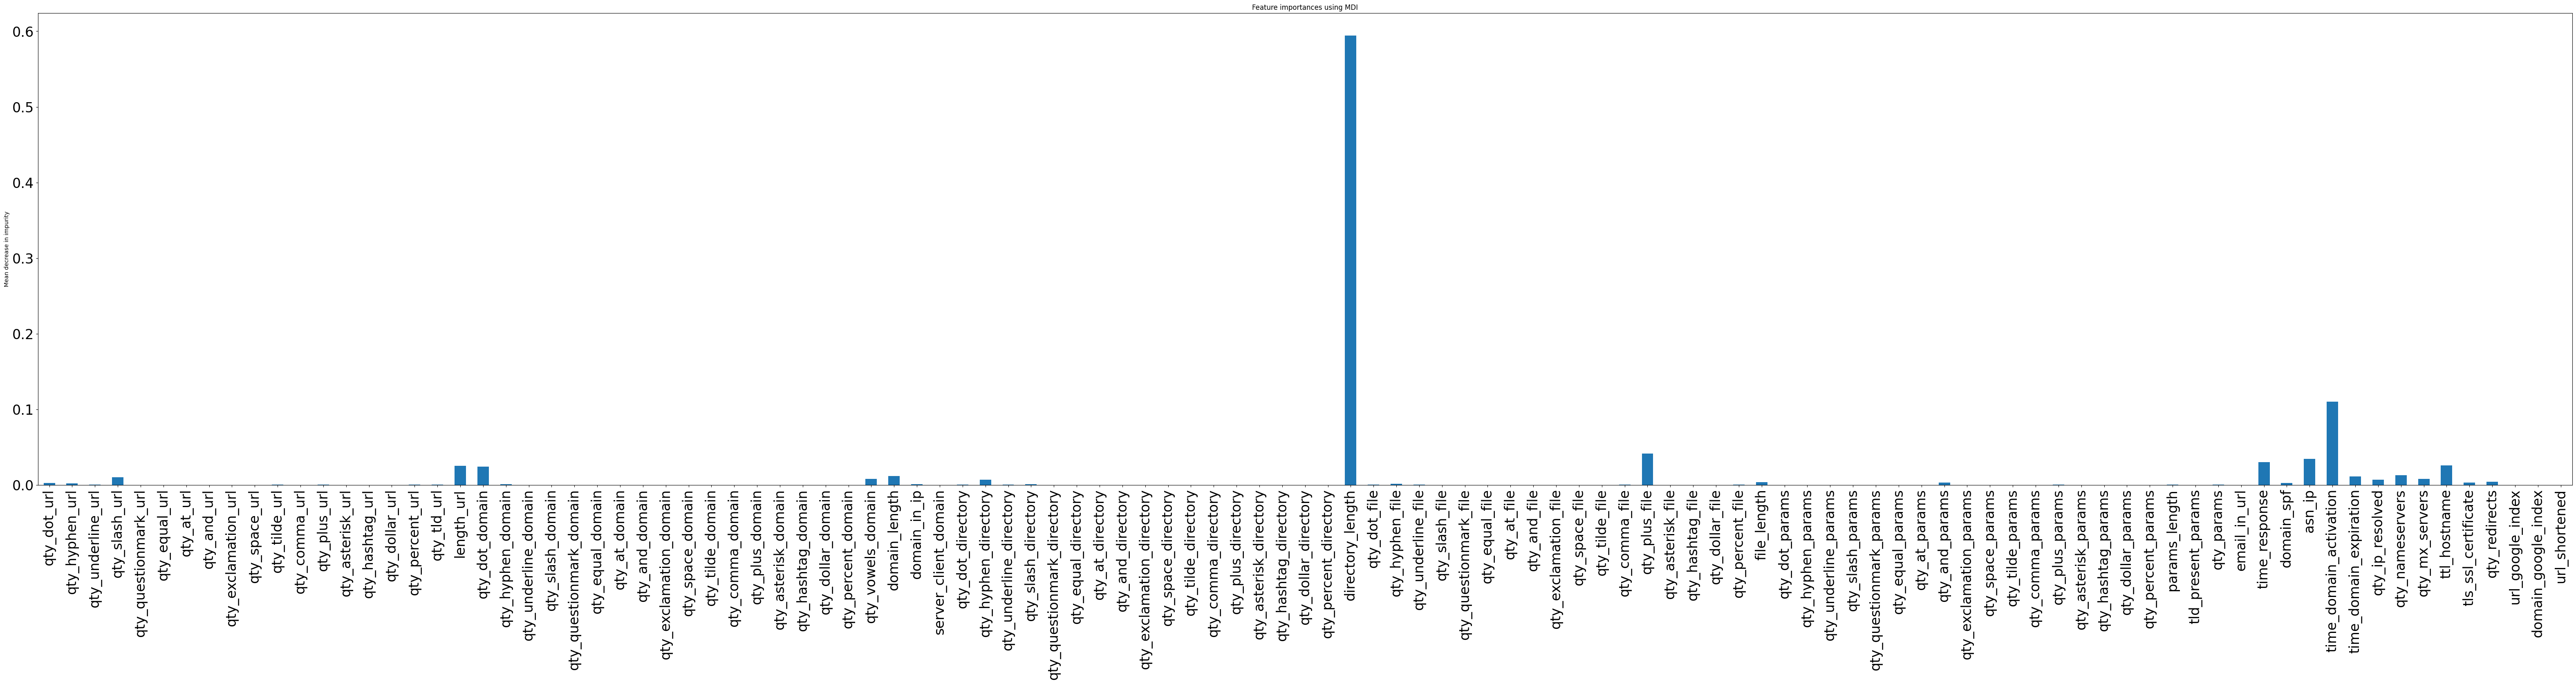

In [14]:
importances = tree.feature_importances_
std = np.std([tree.feature_importances_], axis=0)

tree_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
fig.set_size_inches(80,15)
tree_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.tick_params(labelsize=24)

##**Random Forest Implementation**


In [15]:
forest = sklearn.ensemble.RandomForestClassifier(random_state=0).fit(X_train, y_train);

y_pred = forest.predict(X_train)

training_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

y_pred = forest.predict(X_test)

test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('{:.2%} training accuracy'.format(training_accuracy))
print('{:.2%} training error'.format(1-training_accuracy))
print('{:.2%} test accuracy'.format(test_accuracy))
print('{:.2%} test error'.format(1-test_accuracy))

100.00% training accuracy
0.00% training error
97.07% test accuracy
2.93% test error


##Features Implementation

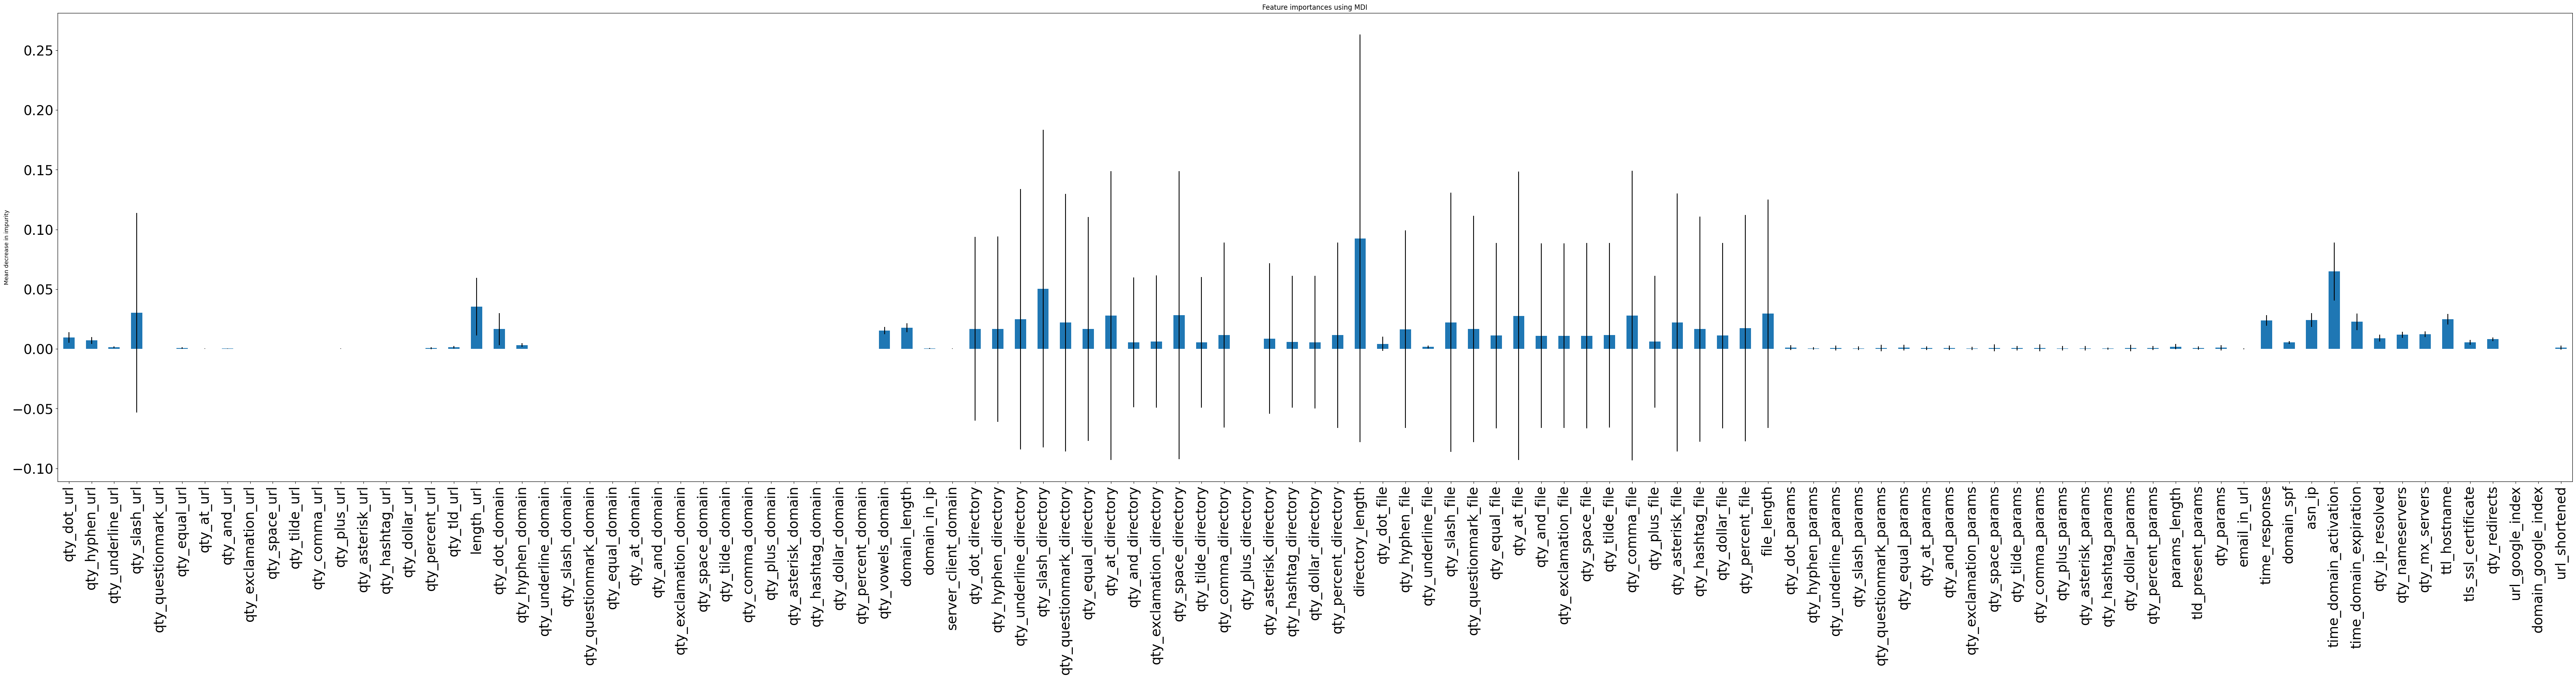

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
fig.set_size_inches(80,15)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.tick_params(labelsize=24)

##**Neural Network Implementation**


In [17]:
import IPython
from markdown import markdown
Markdown = lambda string: IPython.display.HTML(markdown(string))

Markdown("<b style='color: blue'>dfsfd</b>")

# url

#for l in "https://colab.research.google.com/drive/1zrNmACKzueerBEqoCXnrYLjKSrPyzwvt#scrollTo=-V0xg319UUOh":